In [1]:
import torch


import matplotlib.pyplot as plt


import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import argparse
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torch.utils.data.sampler import WeightedRandomSampler
from collections import Counter


In [2]:
class Args(argparse.Namespace):
    data = 'wikipedia'
    bs = 32
    prefix = 'tgn-attn'
    n_degree = 10
    n_head = 2
    n_epoch = 50
    n_layer = 1
    lr = 0.0001
    patience = 5
    n_runs = 1
    drop_out = 0.1
    gpu = 0
    node_dim = 100
    time_dim = 100
    backprop_every = 1
    use_memory = True
    embedding_module = "graph_attention"
    message_function = "identity"
    memory_updater = "gru"
    aggregator = "last"
    memory_update_at_end = False
    message_dim = 100
    memory_dim = 20
    different_new_nodes = False
    uniform = False
    randomize_features = False
    use_destination_embedding_in_message = False
    use_source_embedding_in_message = False
    dyrep = False

args=Args()

BATCH_SIZE = args.bs
NUM_NEIGHBORS = args.n_degree
NUM_NEG = 1
NUM_EPOCH = args.n_epoch
NUM_HEADS = args.n_head
DROP_OUT = args.drop_out
GPU = args.gpu
DATA = args.data
NUM_LAYER = args.n_layer
LEARNING_RATE = args.lr
NODE_DIM = args.node_dim
TIME_DIM = args.time_dim
USE_MEMORY = args.use_memory
MESSAGE_DIM = args.message_dim
MEMORY_DIM = args.memory_dim




In [3]:
data_name="iot-unsw_situation_labels"
DATA_DIR = '/app/scenario_identification/data/iot-unsw_node_classification/ml_iot-unsw_situation_labels.csv'

# OUT_EDGES = os.path.join(DATA_DIR, 'ml_{}_edges.csv'.format(data_name))
# OUT_NOES = os.path.join(DATA_DIR, 'ml_{}_nodes.csv'.format(data_name))
# OUT_EGEE_FEAT = os.path.join(DATA_DIR, 'ml_{}_edge_features.npy'.format(data_name))
# OUT_NODE_FEAT = os.path.join(DATA_DIR, 'ml_{}_node_features.npy'.format(data_name))

OUT_DATASET = os.path.join(DATA_DIR, 'ml_{}.csv'.format(data_name))

df_dataset = pd.read_csv(OUT_DATASET)


sources = df_dataset['u'].values
destinations = df_dataset['i'].values
timestamps = df_dataset['ts'].values
edge_idxs = df_dataset.index.values

sources = df_dataset['u'].values
destinations = df_dataset['i'].values
timestamps = df_dataset['ts'].values


# 'distance', 'latitude', 'longitude', 
node_features_columns = ['shape_status_DEFORMED', 
                         'shape_status_DENTS', 'shape_status_HEAVILY_DAMAGED', 
                         'shape_status_ORIGINAL_MANUFACTURED', 'shape_status_SCRATCHES', 
                         'signal', 'speed', 'status_ACTIVE', 'status_ERROR', 
                         'status_INACTIVE', 'type_EMERGENCY_CENTER', 'type_EMERGENCY_VEHICLE', 
                         'type_INDUCTION_LOOP', 'type_SMART_PHONE', 'type_TRAFFIC_CAMERA', 
                         'type_TRAFFIC_LIGHT', 'type_VEHICLE']

node_features = df_dataset[node_features_columns].values
edge_features = df_dataset['distance'].values.reshape(-1, 1)

src_labels = []
dst_labels = []

nodes_dict = {**{(row['u'], row['ts']): row['label'] for _, row in df_dataset.iterrows()},
             **{(row['i'], row['ts']): row['target_label'] for _, row in df_dataset.iterrows()}}

for u, i, ts in zip(sources, destinations, timestamps):
    
    
    src_label = nodes_dict.get((u, ts), -1) 
    dst_label = nodes_dict.get((i, ts), -1) 
    
    src_labels.append(src_label)
    dst_labels.append(dst_label)

src_labels = np.array(src_labels)
dst_labels = np.array(dst_labels)

NotADirectoryError: [Errno 20] Not a directory: '/app/scenario_identification/data/iot-unsw_node_classification/ml_iot-unsw_situation_labels.csv/ml_iot-unsw_situation_labels.csv'

In [ ]:
col_to_drop = ['i', 'Unnamed: 0', 'level_0', 'level_1','post_label', 'target_label','latitude','longitude']

df_dataset.drop(col_to_drop, axis=1, inplace=True)
df_dataset

,u,ts,distance,label,shape_status_DEFORMED,shape_status_DENTS,shape_status_HEAVILY_DAMAGED,shape_status_ORIGINAL_MANUFACTURED,shape_status_SCRATCHES,signal,...,status_ACTIVE,status_ERROR,status_INACTIVE,type_EMERGENCY_CENTER,type_EMERGENCY_VEHICLE,type_INDUCTION_LOOP,type_SMART_PHONE,type_TRAFFIC_CAMERA,type_TRAFFIC_LIGHT,type_VEHICLE
0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3.0,0.0,127.280104,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.0,0.0,650.989711,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114236,306.0,1333.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
114237,307.0,1333.0,474.525719,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
114238,308.0,1333.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
114239,309.0,1333.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
if node_features.shape[0] == len(src_labels):
    print("The lengths of node_features and src_labels are the same.")
else:
    print("The lengths of node_features and src_labels are not the same.")


is_same_as_label = ((df_dataset['shape_status_ORIGINAL_MANUFACTURED'] == 1) & (df_dataset['label'] == 0)).all()

if is_same_as_label:
    print("The dataset 'shape_status_ORIGINAL_MANUFACTURED' has the same values as the 'label' column.")
else:
    print("The dataset 'shape_status_ORIGINAL_MANUFACTURED' does not have the same values as the 'label' column.")



The lengths of node_features and src_labels are the same.
The dataset 'shape_status_ORIGINAL_MANUFACTURED' does not have the same values as the 'label' column.


Counter({0: 114094, 1: 147})


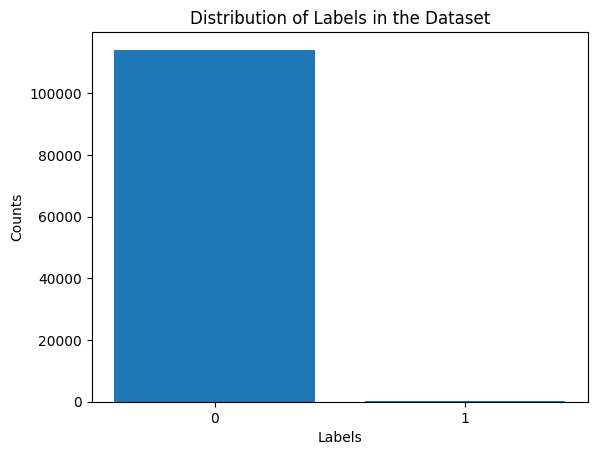

In [ ]:
y = torch.from_numpy(src_labels).to(torch.long)

label_counts = Counter(y.numpy())

# Print the label counts
print(label_counts)

# Prepare data for plotting
labels, counts = zip(*label_counts.items())

# Plot the bar chart
plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Distribution of Labels in the Dataset')
plt.xticks(ticks=labels)  # Set the x-tick labels to be the actual label values
plt.show()


In [ ]:


class_counts = Counter(y.numpy())
num_samples = len(y)
class_weights = {cls: num_samples / count for cls, count in class_counts.items()}

sample_weights = [class_weights[label] for label in y.numpy()]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

balanced_loader = DataLoader(df_dataset, batch_size=32, sampler=sampler)

In [ ]:
src = torch.from_numpy(node_features).to(torch.float)
y = torch.from_numpy(src_labels).to(torch.long)
# msg = torch.from_numpy(edge_features).to(torch.float)


dataset = TensorDataset(src,y)
# loader = DataLoader(dataset, batch_size=32)
# loader = DataLoader(dataset, batch_size=32, sampler=sampler)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# train_loader = DataLoader(train_dataset, batch_size=32)
# test_loader = DataLoader(test_dataset, batch_size=32)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, sampler=sampler)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

src = torch.from_numpy(node_features).to(torch.float)
y = torch.from_numpy(src_labels).to(torch.long)
dataset = TensorDataset(src, y)

# Using StratifiedShuffleSplit to create train and test indices with an 80-20 split
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, test_indices = next(stratified_split.split(src.numpy(), y.numpy()))

# Creating Subset objects for train and test datasets using the indices
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Creating DataLoaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# from torch.utils.data import TensorDataset, DataLoader, random_split
# import torch
# import numpy as np
# from sklearn.utils import resample


# # Find the majority class
# unique_classes, counts = np.unique(src_labels, return_counts=True)
# majority_class = unique_classes[np.argmax(counts)]

# # Separate majority and minority classes
# majority_indices = np.where(src_labels == majority_class)[0]
# minority_indices = np.where(src_labels != majority_class)[0]

# # Undersample majority class
# majority_undersampled = resample(majority_indices,
#                                  replace=False,
#                                  n_samples=len(minority_indices),
#                                  random_state=123)

# # Combine minority class with undersampled majority class
# balanced_indices = np.concatenate([minority_indices, majority_undersampled])

# # Shuffle the balanced indices
# np.random.shuffle(balanced_indices)

# # Create balanced feature and label sets
# src_balanced = node_features[balanced_indices]
# y_balanced = src_labels[balanced_indices]

# src = torch.from_numpy(src_balanced).to(torch.float)
# y = torch.from_numpy(y_balanced).to(torch.long)

# # # Convert back to PyTorch tensors
# # src_balanced = torch.tensor(src_balanced)
# # y_balanced = torch.tensor(y_balanced)

# # Create a balanced TensorDataset
# dataset_balanced = TensorDataset(src, y)

# # Split the balanced dataset into training and testing sets
# train_size = int(0.8 * len(dataset_balanced))
# test_size = len(dataset_balanced) - train_size
# train_dataset, test_dataset = random_split(dataset_balanced, [train_size, test_size])

# # Create DataLoader for training and testing sets
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# len(train_loader), len(test_loader)

In [ ]:
# for src, y in train_loader:
#     print(f"Feature batch shape: {src.size()}")
#     print(f"Labels batch shape: {y.size()}")

In [ ]:
if torch.cuda.is_available():
    mps_device = torch.device("cuda")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("CUDA device not found.")

CUDA device not found.


In [ ]:

# Define the neural network
class NodeClassifier(nn.Module):
    def __init__(self, node_input_dim,  hidden_dim):
        super(NodeClassifier, self).__init__()
        self.fc1 = nn.Linear(node_input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim,1)

    def forward(self, node_features):
        # x = torch.cat((node_features), dim=1) # Concatenate node and edge features
        x = self.fc1(node_features)
        x = self.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

# Model parameters
input_dim = node_features.shape[1]
edge_input_dim = edge_features.shape[1]
hidden_dim = 64
num_classes = len(set(src_labels)) # Number of unique labels



In [ ]:

model = NodeClassifier(input_dim, hidden_dim)


# Loss and optimizer

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
def train(model, loader, optimizer, loss_fn, epochs=10):
    losses = []
    for epoch in range(epochs):
        for node_features,  labels in loader:
            optimizer.zero_grad()
            outputs = model(node_features)
            
            labels = labels.float().view(-1, 1)
            
            loss = loss_fn(outputs,labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")
        losses.append(loss.item())
    return losses

def test(model, loader):
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for node_features, labels in loader:
            outputs = model(node_features)
            _, predicted = torch.max(outputs, 1)
            all_outputs.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_outputs)
    precision = precision_score(all_labels, all_outputs, average='weighted')
    recall = recall_score(all_labels, all_outputs, average='weighted')
    f1 = f1_score(all_labels, all_outputs, average='weighted')

    return accuracy, precision, recall, f1


def plot_loss(losses):
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def plot_node_embeddings(model, node_features_tensor, src_labels):
    embeddings = model.fc1(node_features_tensor).detach().numpy()
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    
    plt.scatter(embeddings_2d[src_labels == 1, 0], embeddings_2d[src_labels == 1, 1], c='red', label='src_label=1')
    plt.scatter(embeddings_2d[src_labels == 0, 0], embeddings_2d[src_labels == 0, 1], c='blue', label='src_label=0')
    
    plt.title('Node Embeddings')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.show()


Epoch 0/10, Loss: 0.0011184309842064977
Epoch 1/10, Loss: 0.0030374254565685987
Epoch 2/10, Loss: 1.8449992467139964e-07
Epoch 3/10, Loss: 0.002343629254028201
Epoch 4/10, Loss: 0.004013757221400738
Epoch 5/10, Loss: 0.0014139065751805902
Epoch 6/10, Loss: 0.00414032069966197
Epoch 7/10, Loss: 0.0015356497606262565
Epoch 8/10, Loss: 2.0923300869668537e-09
Epoch 9/10, Loss: 0.0015365798026323318


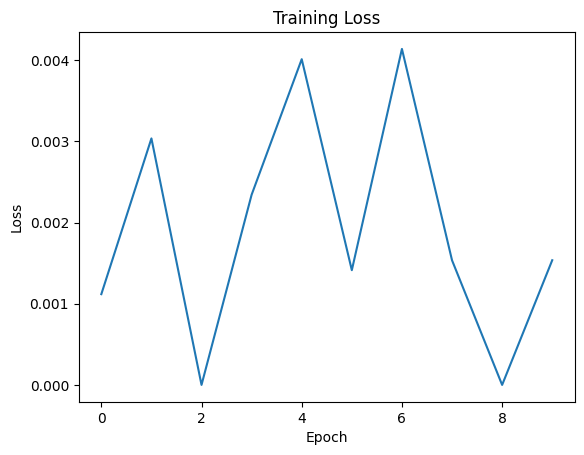

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9987307978467329, Precision: 0.9974632065675717, Recall: 0.9987307978467329, F1: 0.9980965997443537


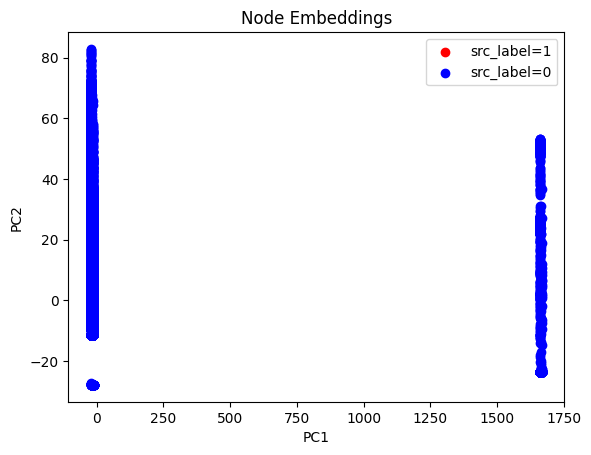

In [ ]:
# Train the model
losses = train(model, train_loader, optimizer, loss_fn)

# Plot the loss
plot_loss(losses)

# Test the model
accuracy, precision, recall, f1 = test(model, test_loader)
print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}')

# Plot the node embeddings
plot_node_embeddings(model, src, y)


